# Inštalácia knižnic

In [ ]:
import pandas as pd 
import os
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
nltk.download('averaged_perceptron_tagger')
import io
import re
import string
import tensorflow as tf
import tqdm

from tensorflow.keras import Model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dot, Embedding, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import pickle 


In [ ]:
!pip install umap-learn
!pip uninstall umap
!pip install holoviews
!pip install -U ipykernel
!pip install wandb

In [ ]:
!pip install benepar
!pip install cython numpy
!pip install Keras
#!pip install --upgrade gensim

In [ ]:
import multiprocessing
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import gensim
import numpy as np
import umap.umap_ as umap
import sklearn.datasets
import numpy as np
import matplotlib
!pip install bokeh
!conda install -c pyviz holoviews bokeh
!pip install datashader

import umap.umap_ as umap


import umap
import umap.plot

In [5]:
from keras.layers.recurrent import LSTM, RNN
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.layers import Dense, Activation,GRU, SimpleRNN
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.layers import Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, RMSprop

# Inicializácia


In [6]:
class Sentence:
  def __init__(self):
    self.words = []
    self.wholeSentence = None
    self.sentiment = None
    self.tree = None
    self.NerTag = None

  def appendWords(self, word): 
    self.words.append(word) 

class Word:
  def __init__(self):
    self.word = None
    self.lemma = None
    self.synsetName = None
    self.synsetDefinition = None
    self.posTag = None
    self.grammarTag = None
    self.synonyma = []
    self.antonyma = None
    self.negation = None


In [15]:
from google.colab import drive
drive.mount('/content/drive')

path_data = '/content/drive/My Drive/'
path = os.path.join(path_data, 'data_preprocessed.csv')
data = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
with open("/content/drive/My Drive/Sentence", 'rb') as ff:
  firstlistofSentences = pickle.load(ff)
  ff.close()

In [17]:
len(firstlistofSentences)

10637

In [10]:
AUTOTUNE = tf.data.AUTOTUNE


In [18]:
def data_augumentation(listofSentences,dataset):
  augumented = []
  data2words = []
  sentiments = []

  for sentence in listofSentences:
    new_sentence = Sentence()
    new_whole_sentence = ''
    counter = 0
    for word in sentence.words:
      new_word = Word()
      if not word.synonyma: #len(word.synonyma) == 0
        new_word.lemma = word.lemma
        new_word.posTag = word.posTag
        new_word.word = word.lemma
      else:
        counter+=1
        new_word.lemma = word.synonyma[0]
        new_word.posTag = word.posTag
        new_word.word = word.synonyma[0]
      new_sentence.appendWords(new_word)
      new_whole_sentence= new_whole_sentence + ' ' + new_word.word

    if counter == 0:
      continue
    new_sentence.wholeSentence= new_whole_sentence
    augumented.append(new_sentence)
    data2words.append(new_whole_sentence)
    sentiments.append(sentence.sentiment)
  d = {'Pos-Lem Sen without tags': data2words, 'News': data2words, 'Sentiment': sentiments}
  dataset2 = pd.DataFrame(d) 
  dataset3 = pd.concat([dataset, dataset2], ignore_index = True)
  dataset3.reset_index()
  return augumented, dataset3

augumentedlist,data= data_augumentation(firstlistofSentences,data)
listofSentences = firstlistofSentences + augumentedlist

In [19]:
len(listofSentences)

21153

In [11]:
# listofSentences = firstlistofSentences
import pickle 
filehandler = open("/content/drive/My Drive/AugumentedTwitterSentence", 'wb') 
pickle.dump(listofSentences, filehandler, pickle.HIGHEST_PROTOCOL)
filehandler.close()

# data.to_csv('data_preprocessed.csv')
# !cp data_preprocessed.csv "/content/drive/My Drive/"

# Vocabulary from whole dataset

KERAS

In [12]:
data['Vocab-Sentence'] = None
data['Inverse-Vocab-Sentence'] = None
data['Vocab-Sequence'] = None

vocab, i = {}, 1
vocab['<pad>'] = 0

for index,sentence in enumerate(listofSentences):

  sentence = sentence.words
  sequence = []
  for word  in sentence:
    #print(word.word)
    if word.lemma not in vocab:
      vocab[word.lemma] = i
      i+=1
    sequence.append(vocab[word.lemma])

  inverse_vocab = {index: token for token, index in vocab.items()}
  
  data.at[index,'Vocab-Sentence'] = vocab
  data.at[index,'Inverse-Vocab-Sentence'] = inverse_vocab
  data.at[index,'Vocab-Sequence'] = sequence

In [ ]:
# HELP CELLS REMOVE AFTER !!! BO BUDE BORDEL AKO SVINA
for index,row in data.iterrows():
  if index == 50:
    print(row['Pos-Lem Sen without tags'])
    print(row['Vocab-Sentence'])
    print(row['Inverse-Vocab-Sentence'])
    print(row['Vocab-Sequence'])

# if index == 1:
#   print(vocab)
#   print(sequence)


In [20]:
#test data do sekvencii
with open("/content/drive/My Drive/Test_Twitter_Sentences", 'rb') as ff:
  testlistofSentences = pickle.load(ff)
  ff.close()

path = os.path.join(path_data, 'tweetsdataset.csv')
testdata = pd.read_csv(path)
testdata=testdata.drop(columns=['Unnamed: 0'])
dataset = tf.data.Dataset.from_tensor_slices(data['Pos-Lem Sen without tags'])
data_test = tf.data.Dataset.from_tensor_slices(testdata['Pos-Lem Sen without tags'])
combined_dataset = dataset.concatenate(data_test)

# Generovanie skip-gramov


Zjednodušenie dát do Word2Vec vytvorenim skip-gram párov zo sekvencii, ktoré som si vyššie vytvorila s danou velkostou okna z vety v rozpati 0 az po velkost slovnika.



In [ ]:
# data=pd.concat([data, testdata], ignore_index = True)
# data.reset_index()

In [20]:
def data_to_word2vec(sequences,window_size, num_ns, seed, vocabulary_len):
  data['Skip-Grams'] = None
  targets, contexts, labels = [], [], []
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocabulary_len)


  # JJ
  # for index,row in data.iterrows():
    # sequence = row['Vocab-Sequence']   
  for index, sequence in enumerate(tqdm.tqdm(sequences)):
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocabulary_len,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)
  
    data.at[index,'Skip-Grams'] = positive_skip_grams

    for target_word, context_word in positive_skip_grams:
      context_trieda = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
      negativne_vzorky, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_trieda,  # trieda ktora ma byt vzorkovan ako 'positive'
          num_true=1,  # kazdy pozitivny skip-gram má 1 positive context triedu
          num_sampled=num_ns,  # number of negative context words to sample
          unique=True,  # unikatne negativne vzorky
          range_max=vocabulary_len,  # pick index of the samples from [0, vocab_size]
          seed=SEED,  # seed for reproducibility
          name="negative_sampling"  # name of this operation
      )

      negativne_vzorky = tf.expand_dims(negativne_vzorky, 1)
      kontext = tf.concat([context_trieda, negativne_vzorky], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")
      targets.append(target_word)
      contexts.append(kontext)
      labels.append(label)
    # if index == 0:
    #   for target, context in positive_skip_grams[:5]:
    #     print(f"({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})")
    #   print(negative_sampling_candidates)
    #   print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])
  return targets, contexts, labels

In [21]:

vectorize_layer = TextVectorization(
    # standardize=custom_standardization,
    # max_tokens=len(data['Vocab-Sentence']),
    output_mode='int' #try  EXPERIMENTALY tfidf
    # output_sequence_length=sequence_length
    )

vectorize_layer.adapt(combined_dataset.batch(1024))
invvocab = vectorize_layer.get_vocabulary()
dataset_vector = combined_dataset.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()
sequences = list(dataset_vector.as_numpy_iterator())


In [ ]:
for seq in sequences[:5]:
  print(f"{seq} => {[invvocab[i] for i in seq]}")

In [16]:
len(invvocab)

51854

# WORD2VEC KERAS MODEL

In [ ]:
SEED = 42
# Nastavenie počtu negativnych vzoriek : pozitivny kontext
num_ns = 4
window_size = 2
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

targets, contexts, labels = data_to_word2vec(
    sequences= sequences,
    window_size=2,
    num_ns=4,
    seed=SEED,
    vocabulary_len=len(invvocab)
    )
print(len(targets), len(contexts), len(labels))



dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

del targets, contexts, labels

In [ ]:
class Word2Vec(Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=num_ns+1)
    self.dots = Dot(axes=(3, 2))
    self.flatten = Flatten()

  def call(self, pair):
    target, context = pair
    word_emb = self.target_embedding(target)
    context_emb = self.context_embedding(context)
    dots = self.dots([context_emb, word_emb])
    return self.flatten(dots)

def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [ ]:
embedding_dim = 128
vocab_size = len(invvocab)
# vocab_size = len(vectorize_layer.get_vocabulary())
word2vec = Word2Vec(vocab_size, embedding_dim)

word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
# %tensorboard --logdir logs


UsageError: Line magic function `%tensorboard` not found.


In [ ]:
wordvecs=word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])


Epoch 1/20
277/277 [==============================] - 16s 54ms/step - loss: 1.6040 - accuracy: 0.2500
Epoch 2/20
277/277 [==============================] - 14s 50ms/step - loss: 1.5145 - accuracy: 0.4258
Epoch 3/20
277/277 [==============================] - 14s 51ms/step - loss: 1.3504 - accuracy: 0.5460
Epoch 4/20
277/277 [==============================] - 14s 51ms/step - loss: 1.1399 - accuracy: 0.6759
Epoch 5/20
277/277 [==============================] - 14s 50ms/step - loss: 0.9441 - accuracy: 0.7491
Epoch 6/20
277/277 [==============================] - 14s 50ms/step - loss: 0.7814 - accuracy: 0.7983
Epoch 7/20
277/277 [==============================] - 14s 50ms/step - loss: 0.6516 - accuracy: 0.8357
Epoch 8/20
277/277 [==============================] - 14s 51ms/step - loss: 0.5492 - accuracy: 0.8643
Epoch 9/20
277/277 [==============================] - 14s 50ms/step - loss: 0.4679 - accuracy: 0.8875
Epoch 10/20
277/277 [==============================] - 14s 50ms/step - loss: 0.402

In [ ]:
del dataset
del dataset_vector
del listofSentences

In [ ]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocabularyfrom = vectorize_layer.get_vocabulary()

print(len(weights))
print(len(vocabularyfrom))


17353
17353


In [ ]:

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')
weightskeras = []
vocabularykeras = []

for index, word in enumerate(vocabularyfrom):
  # if index == 0:
  #   continue  # skip 0, it's padding - cant skip, change of position for words in embeddings
  vec = weights[index]
  weightskeras.append(weights[index])
  vocabularykeras.append(word)
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()
# use if you want to download files
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

# WORD2VEC FROM GENSIM

In [17]:
def gensimword2vec(listfinal): 
  w2v_model = gensim.models.Word2Vec(min_count=1,
                      window=2,
                      size =128, #vector_
                      sample=6e-5, 
                      alpha=0.03, 
                      min_alpha=0.0007, 
                      negative=20,
                      sg = 1
  )
  w2v_model.build_vocab(listfinal, progress_per=10000) # Pos-Lem Sen without tags

  w2v_model.train(listfinal, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
  return w2v_model

In [18]:
result_list = [tmp_sentence.words for tmp_sentence in listofSentences]
result_list_test = [tmp_sentence.words for tmp_sentence in testlistofSentences]

final_list = []
for tmp_words in result_list:
  final_list.append([tmp_w.lemma for tmp_w in tmp_words])
for tmp_words in result_list_test:
  final_list.append([tmp_w.lemma for tmp_w in tmp_words])

w2v_model = gensimword2vec(final_list)


# EMBEDDING METRIX



In [ ]:
w2v_model.save('/content/drive/My Drive/word2vector_super_2022.model')

In [ ]:
w2v_model = Word2Vec.load("/content/drive/My Drive/word2vector_super_2021.model")

In [22]:
# Gensim model embedding matrix for training
def do_embed_matrix(vocabsize, model, invocab):
  words_found = 0
  words_missing = 0
  embedding_matrix = np.zeros((vocabsize,128))
  for index, slovko in enumerate(invocab):
    if slovko not in model.wv:
      words_missing += 1
      continue
    else:
      embedding_matrix[index] = model.wv[slovko] # * tfidfDict[slovko]
      words_found += 1
  print('Vocab len: {vl} Words found: {vf} Words missing {vm}'.format(vl=vocabsize, vf=words_found, vm=words_missing))
  return embedding_matrix


embedding_matrix=do_embed_matrix(len(invvocab),w2v_model,invvocab)


Vocab len: 51854 Words found: 50894 Words missing 960


In [18]:
# Iba pre vizualizaciu dat
labels = []
post_tags = []
new_embeddings = []

for sentence in listofSentences:
  for word in sentence.words:
    if word.lemma in labels:
      continue
    labels.append(word.lemma)
    post_tags.append(word.posTag)
    new_embeddings.append(w2v_model.wv[word.lemma])
    
# sklearn.utils.shuffle(new_embeddings, post_tags)

In [ ]:
# Iba pre vizualizaciu
keras_labels = []
keras_post_tags = []
keras_new_embeddings = []

dictionary = {}
for index, word in enumerate(vocabularykeras):
    dictionary[word] = weightskeras[index]

for sentence in listofSentences:
  for word in sentence.words:
    if word.lemma in keras_labels or word.lemma not in vocabularykeras:
      continue
    keras_labels.append(word.lemma)
    keras_post_tags.append(word.posTag)
    keras_new_embeddings.append(dictionary[word.lemma])
    
# sklearn.utils.shuffle(keras_new_embeddings, keras_post_tags)

# KERAS WORD2VEC MODEL UMAP VIZUALIZÁCIA

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:2448: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  y_ = check_array(y, ensure_2d=False)[index]


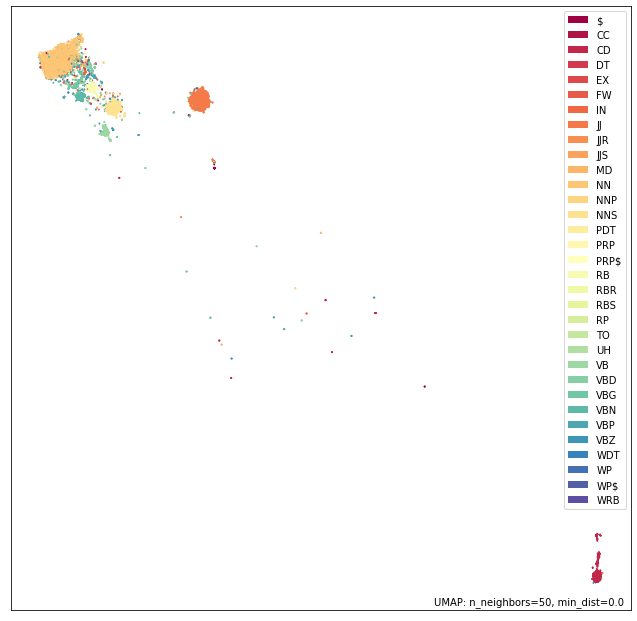

In [ ]:

reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=2,
    random_state=42)

embeddingkeras = reducer.fit(keras_new_embeddings, y=keras_post_tags)
f = umap.plot.points(embeddingkeras,labels=np.asarray(keras_post_tags)) #,labels=np.asarray(post_tags)

# GENSIM WORD2VEC MODEL UMAP VIZUALIZÁCIA

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:2448: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  y_ = check_array(y, ensure_2d=False)[index]


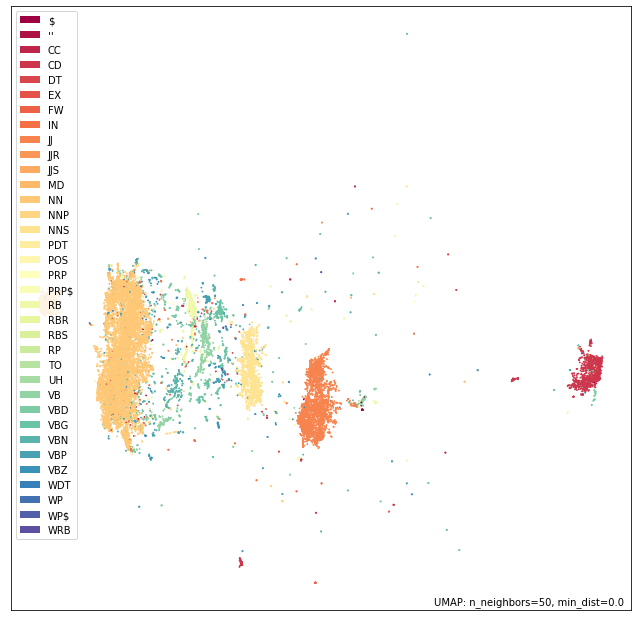

In [ ]:

reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=2,
    random_state=42)

embedding = reducer.fit(new_embeddings, y=post_tags)
# plt.scatter(new_embeddings[:, 0], new_embeddings[:, 1], c=np.asarray(post_tags), s=0.1, cmap='Spectral');
f = umap.plot.points(embedding,labels=np.asarray(post_tags)) #,labels=pendigits.target

In [79]:
senlabels = []
sen_tags = []
sennew_embeddings = []
for sentence in listofSentences:
  sentimentforW = sentence.sentiment
  for word in sentence.words:
    if word.lemma in senlabels:
      continue
    senlabels.append(word.lemma)
    if sentence.sentiment == None or sentence.sentiment == '' :
      #print("whaat")
      sen_tags.append(float(0))
    elif len(sentence.sentiment.split(" ")) == 1:
      #print(sentence.sentiment)
      sen_tags.append(sentence.sentiment)
    sennew_embeddings.append(w2v_model.wv[word.lemma])



In [ ]:
sen_tags

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


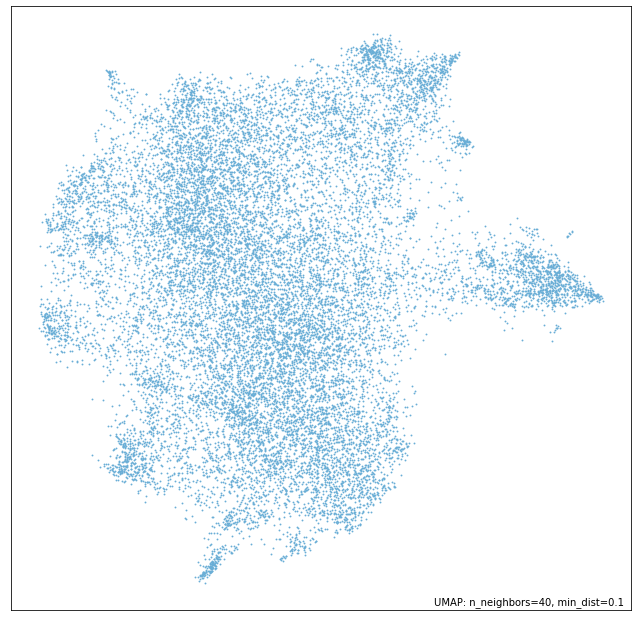

In [97]:
reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=2,
    random_state=42)

embedding = reducer.fit(sennew_embeddings)#,, y=sen_tags

f = umap.plot.points(embedding) #,labels=pendigits.target,labels=np.asarray(sen_tags)

In [ ]:
f = umap.plot.points(embedding,values=labels) #,labels=pendigits.target,labels=np.asarray(sen_tags)


projekcia word2vec vectorov z modelu

https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/akuchotrani/cc9296c2e566d495057ae27ea0da2d42/raw/8b79fcee60094861c11ac58006dbe03230ca8fbc/test_projector.json

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
import datetime, os
from tensorboard import notebook
notebook.list() # View open TensorBoard instances
notebook.display(port=6006, height=1000) 

Check-list:

https://hangle.fr/post/word2vec/

https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca
https://www.sciencedirect.com/science/article/pii/S0306457320309286

Clustering? K-means? TSNE

https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

# LSTM / GRU MODEL

In [23]:
embedding_size = 128
vocab_size = embedding_matrix.shape[0]  # toto je gensim word2vec - (+ 1 asi)
# vocab_size_keras = len(keras_labels)  # keras je moj word2vec

# print('Gensim vocab_size is: {gensim_len}\nKeras vocab_size is: {keras_len}'.format(gensim_len=vocab_size, keras_len=vocab_size_keras))

In [24]:
train_sequences = sequences[:len(data)]
test_sequences = sequences[len(data):]

In [25]:
Y = pd.get_dummies(data['Sentiment']).values
print(Y.shape)

(21153, 3)


In [ ]:
# word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, 
#                            background_color="black", max_words=2000, mask=avengers_mask, 
#                            contour_width=1, contour_color="steelblue", 
#                            colormap="nipy_spectral").generate(tweets)

In [26]:
MAX_SEQUENCE_LENGTH = 50
X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (21153, 50)


In [27]:


plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [28]:
X_t, Y_t = sklearn.utils.shuffle(X_train, Y)

# wandb

In [30]:
import wandb

wandb.login()

config = {'model': model.get_config()}

run = wandb.init(project="sentiment-analysis-main-augumented")

wandb.config.update(config)


def batch_output(batch, logs):
    if batch % 50 == 0:
        wandb.log({"loss": logs['loss']})
        wandb.log({"accuracy": logs['accuracy']})

def epoch_output(batch, logs):
    wandb.log({"loss": logs['loss']})
    wandb.log({"accuracy": logs['accuracy']})
    wandb.log({"val_loss": logs['val_loss']})
    wandb.log({"val_accuracy": logs['val_accuracy']})

batch_logback = LambdaCallback(on_batch_end=batch_output)
epoch_logback = LambdaCallback(on_epoch_end=epoch_output)


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: adikke (use `wandb login --relogin` to force relogin)


# Training

In [37]:
print(vocab_size)

51854


In [ ]:
# Can delete - finding best parameters
import random
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, GRU, SimpleRNN, LSTM, RNN, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.layers import Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers

def create_model():
  # define LSTM model
  conv_n = random.randint(30, 60)
  rnn_n = random.randint(30, 60)
  dense_n = random.randint(30, 60)
  conv_kernel = random.randint(6, 10)

  spatial_dropout = round(random.uniform(0.2, 0.8), 1)
  regul = round(random.uniform(0.0005, 0.05), 4)
  rnn_dropout = round(random.uniform(0.2, 0.8), 1)
  rnn_regul = round(random.uniform(0.0005, 0.05), 4)

  lstm_type = random.choice([True, False])

  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[embedding_matrix], trainable=True, input_length=MAX_SEQUENCE_LENGTH))
  model.add(SpatialDropout1D(spatial_dropout))
  model.add(Conv1D(conv_n, kernel_size=conv_kernel,kernel_regularizer=regularizers.l2(regul), padding='same'))
  model.add(MaxPooling1D(pool_size=2))
  if lstm_type:
    model.add(Bidirectional(LSTM(rnn_n,dropout=rnn_dropout, kernel_regularizer=regularizers.l2(rnn_regul))))
    model_name = '{}-l{}-{}-{}'.format(conv_n, rnn_n, dense_n, conv_kernel)
  else:
    model.add(GRU(rnn_n, dropout=rnn_dropout, kernel_regularizer=regularizers.l2(rnn_regul)))
    model_name = '{}-g{}-{}-{}'.format(conv_n, rnn_n, dense_n, conv_kernel)
  # model.add(SimpleRNN(128))
  model.add(Dense(dense_n, activation='relu'))
  model.add(Dense(3, activation='softmax'))

  return model, model_name

#%%

epochs = 40
batch_size = 32
early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
reduce_lro = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)


#%%

from tensorflow.keras.optimizers import Adam, RMSprop


for i in range(75):
    lr = round(random.uniform(0.0005, 0.01), 4)
    model, model_name = create_model()

    opt_type = random.choice(['adam', 'rmsprop'])

    model_name += '-'
    model_name += 'a' if opt_type == 'adam' else 'r'
    model_name += str(lr)

    opt = Adam(lr=lr) if opt_type == 'adam' else RMSprop(lr=lr)

    config = {'model': model.get_config(), 'opt_lr': lr, 'opt': opt_type}

    run = wandb.init(project="sentiment-analysis-main-augumented", name=model_name)

    wandb.config.update(config)

    model.compile(optimizer=opt,metrics=['accuracy'], loss='categorical_crossentropy')

    history = model.fit(X_t, Y_t, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[early_stop,reduce_lro,batch_logback,epoch_logback])
    run.finish()

In [31]:
epochs = 40 
batch_size = 32
early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
reduce_lro = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
opt = Adam(lr = 0.0005)
model.compile(optimizer=opt,metrics=['accuracy'], loss='categorical_crossentropy')



In [ ]:
history = model.fit(X_t, Y_t, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[early_stop,reduce_lro,batch_logback,epoch_logback])
run.finish()

In [ ]:
loss, accuracy = model.evaluate(X_t, Y_t, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))

333/333 [==============================] - 3s 9ms/step - loss: 1.8404 - accuracy: 0.3862
Training Accuracy: 0.3862


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.save('/content/drive/My Drive/')

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/')

In [ ]:
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
result = model.predict(X_test)
result = result.argmax(axis=-1)

In [ ]:
result_map = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}

def map_results(res):
  return result_map[res]

final_res = list(map(map_results, result))
list(final_res)
testdata['Sentiment']=final_res

testdata.to_csv('classified_test_data.csv')
!cp classified_test_data.csv "/content/drive/My Drive/"

LOAD LSTM AND PREDICT

In [25]:
len(sequences[len(data):])

22677

In [26]:
test_sequences = sequences[len(data):]

In [30]:
modelLSTM = keras.models.load_model('/content/drive/My Drive/LSTM/bilstm_model.h5')

In [33]:
X_test = pad_sequences(test_sequences, maxlen=50, padding='post')
result = modelLSTM.predict(X_test)
result = result.argmax(axis=-1)

In [34]:
result_map = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}

def map_results(res):
  return result_map[res]

final_res = list(map(map_results, result))
list(final_res)
testdata['SentimentLSTM']=final_res

testdata.to_csv('classified_test_data.csv')
!cp classified_test_data.csv "/content/drive/My Drive/"